# Chapter 4: Deep Convolutional GAN (DCGAN)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

import session_info
session_info.show()

In [3]:
np.random.seed(42)
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    #model.add(Input(shape=z_dim))
    #model.add(Dense(256*7*7))
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    #model.add(Activation('tanh'))

    return model

## Discriminator

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    #model.add(Input(shape = img_shape))
    #model.add(Conv2D(32, kernel_size=3, strides=2, padding='same'))
    
    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [10]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [12]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose = 0)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose = 0)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [13]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z, verbose=0)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

500 [D loss: 0.117460, acc.: 97.27%] [G loss: 4.946035]
1000 [D loss: 0.075809, acc.: 99.22%] [G loss: 5.309681]
1500 [D loss: 0.220251, acc.: 91.02%] [G loss: 2.770491]
2000 [D loss: 0.312590, acc.: 83.20%] [G loss: 2.477393]
2500 [D loss: 0.450604, acc.: 80.47%] [G loss: 2.174108]
3000 [D loss: 0.333504, acc.: 86.72%] [G loss: 2.434813]
3500 [D loss: 0.243673, acc.: 91.02%] [G loss: 2.606408]
4000 [D loss: 0.253363, acc.: 89.84%] [G loss: 2.279436]
4500 [D loss: 0.212855, acc.: 91.41%] [G loss: 2.621593]
5000 [D loss: 0.184260, acc.: 91.80%] [G loss: 3.848732]
5500 [D loss: 0.137457, acc.: 95.31%] [G loss: 4.820778]
6000 [D loss: 0.051119, acc.: 98.05%] [G loss: 5.237890]
6500 [D loss: 0.008910, acc.: 100.00%] [G loss: 7.132660]
7000 [D loss: 0.121732, acc.: 96.09%] [G loss: 4.204355]
7500 [D loss: 0.060938, acc.: 98.05%] [G loss: 4.402969]
8000 [D loss: 0.094429, acc.: 96.48%] [G loss: 4.078651]
8500 [D loss: 0.052572, acc.: 98.05%] [G loss: 5.004061]
9000 [D loss: 0.202037, acc.: 9

C:\Users\silve\AppData\Local\Temp\ipykernel_20692\459240716.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(image_grid_rows,


11000 [D loss: 0.065982, acc.: 98.44%] [G loss: 3.724930]
11500 [D loss: 0.166113, acc.: 95.31%] [G loss: 3.844934]
12000 [D loss: 0.125322, acc.: 95.31%] [G loss: 3.403450]
12500 [D loss: 0.110444, acc.: 96.88%] [G loss: 2.864139]
13000 [D loss: 0.052265, acc.: 98.05%] [G loss: 3.668486]
13500 [D loss: 0.127844, acc.: 95.31%] [G loss: 4.139430]
14000 [D loss: 0.080464, acc.: 97.27%] [G loss: 4.025092]
14500 [D loss: 0.053515, acc.: 100.00%] [G loss: 3.944496]
15000 [D loss: 0.187983, acc.: 94.53%] [G loss: 3.203899]
15500 [D loss: 0.146071, acc.: 96.09%] [G loss: 6.063290]
16000 [D loss: 0.050768, acc.: 98.05%] [G loss: 5.897557]
16500 [D loss: 0.081304, acc.: 97.66%] [G loss: 4.764990]
17000 [D loss: 0.124772, acc.: 95.70%] [G loss: 4.568470]
17500 [D loss: 0.025831, acc.: 99.61%] [G loss: 4.677257]
18000 [D loss: 0.044530, acc.: 98.83%] [G loss: 4.192852]
18500 [D loss: 0.076009, acc.: 98.05%] [G loss: 4.391985]
19000 [D loss: 0.114872, acc.: 96.48%] [G loss: 6.352724]
19500 [D loss

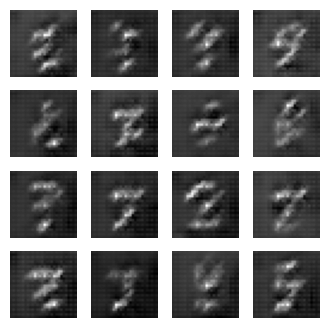

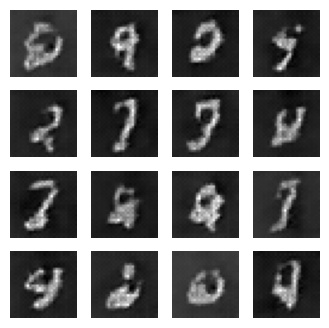

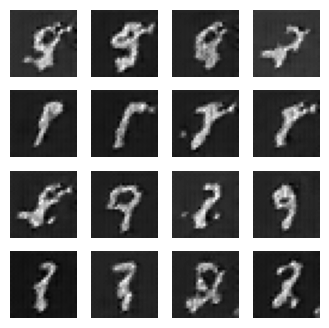

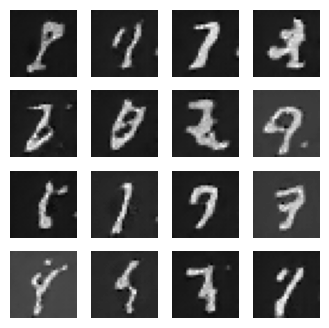

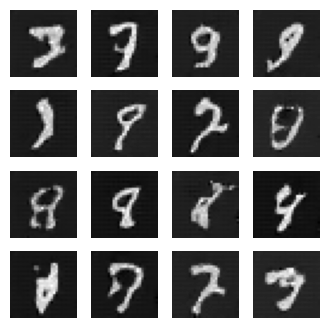

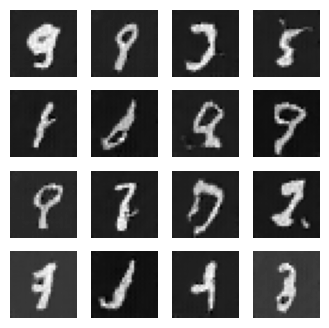

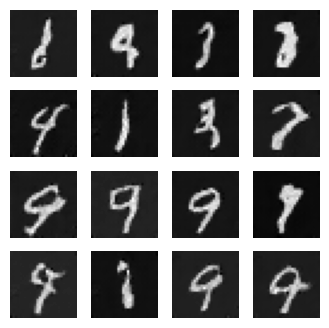

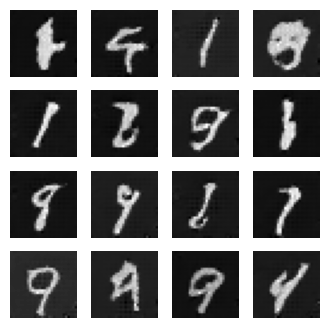

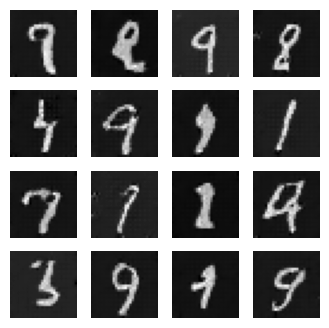

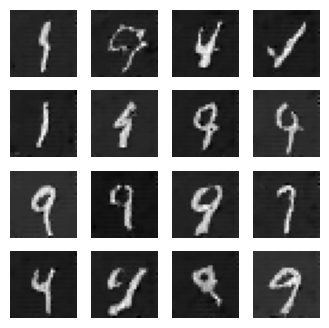

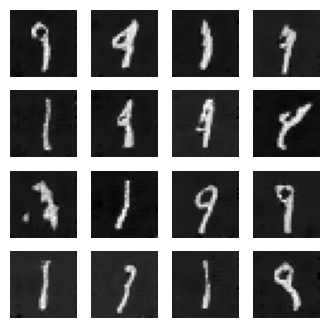

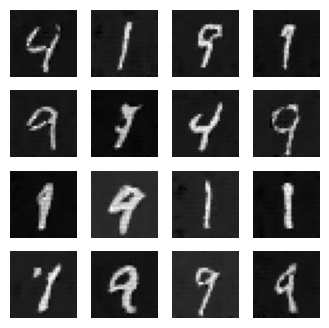

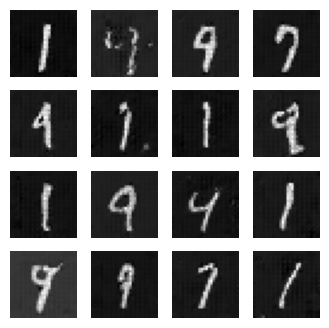

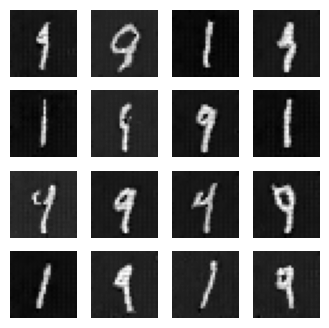

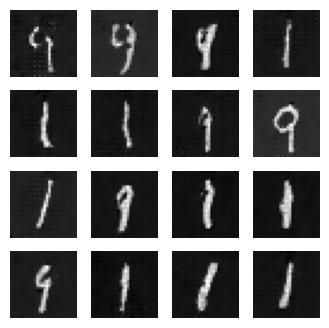

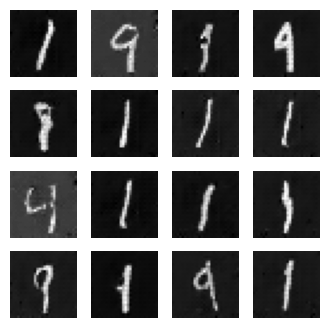

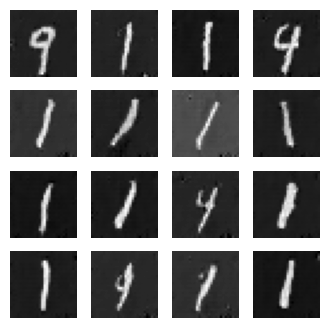

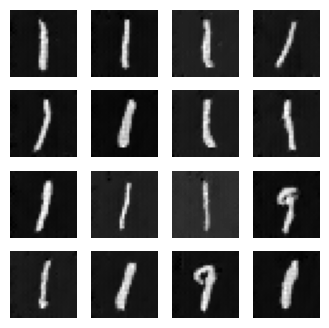

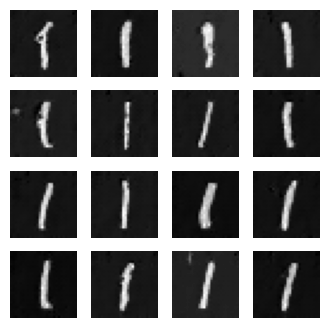

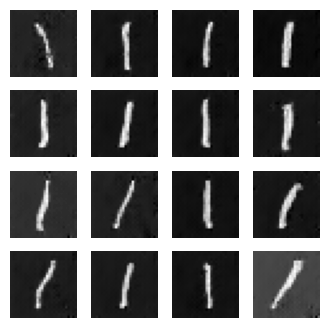

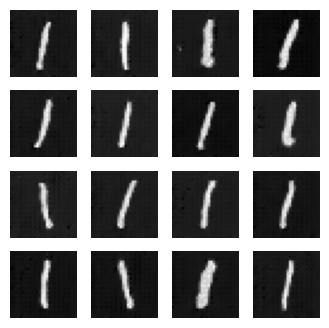

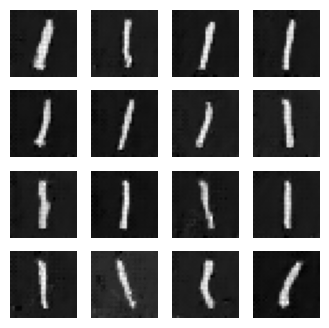

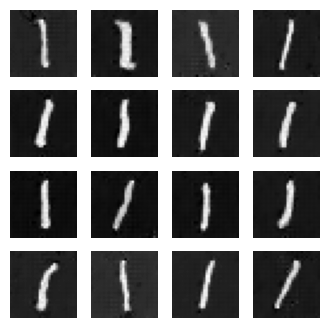

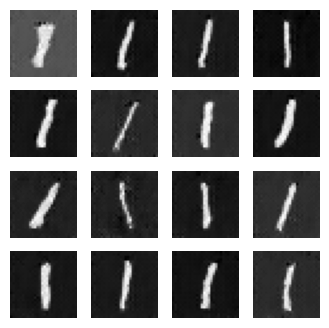

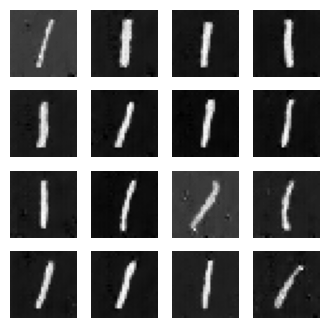

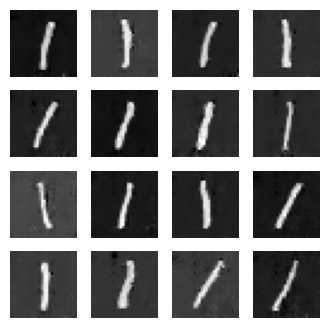

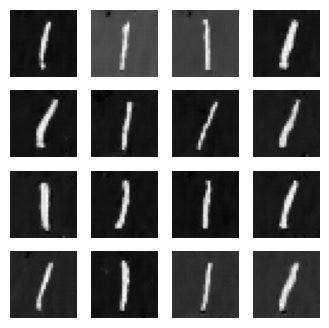

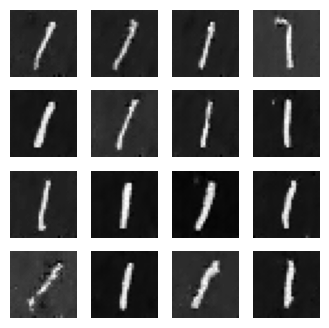

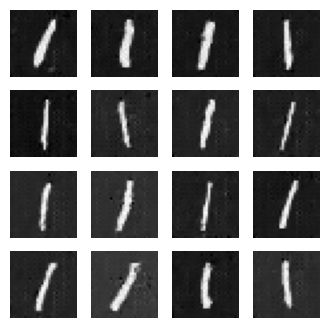

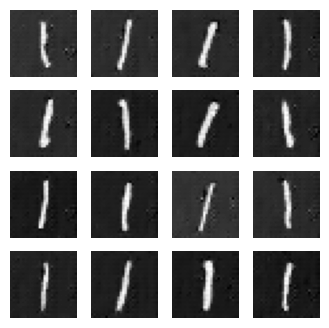

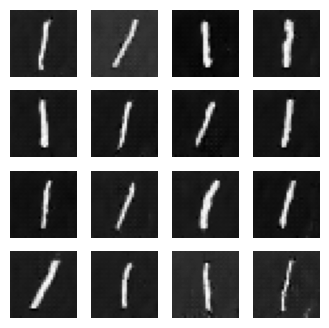

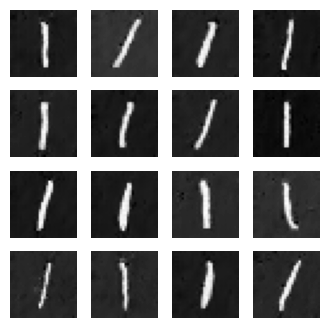

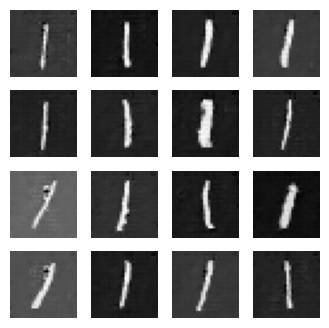

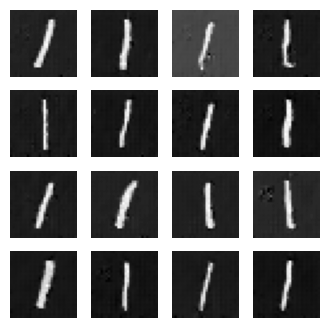

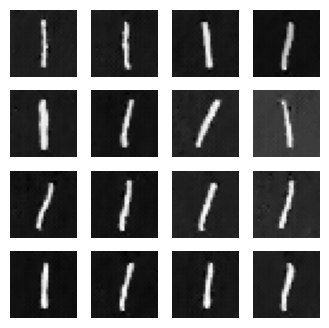

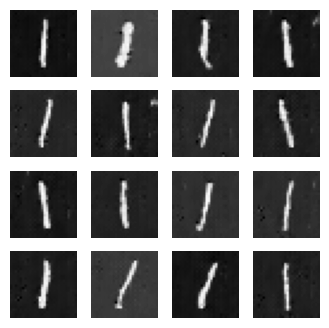

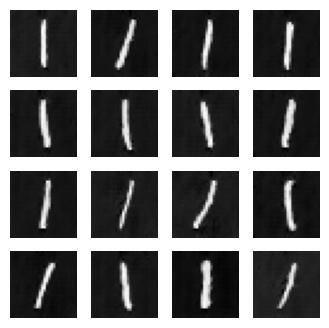

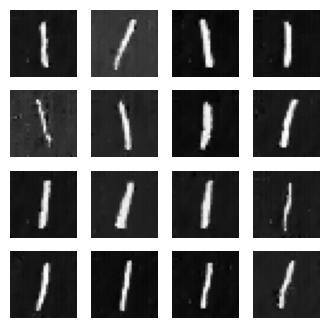

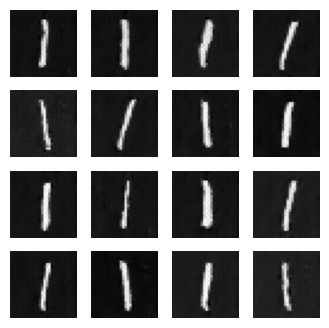

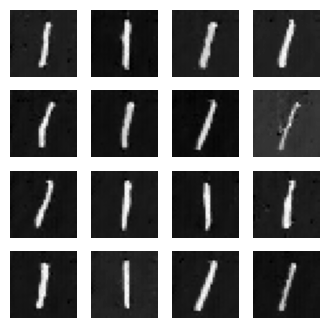

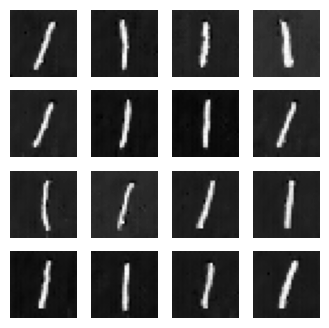

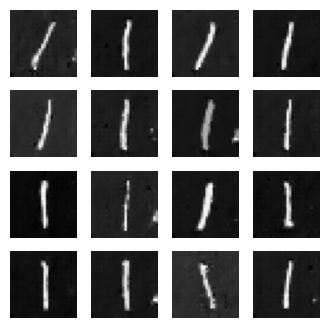

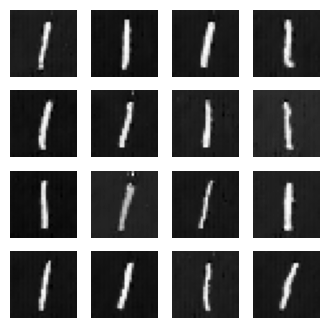

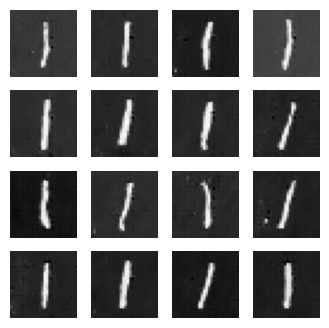

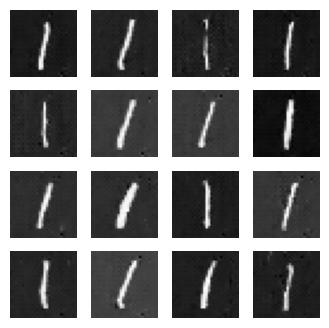

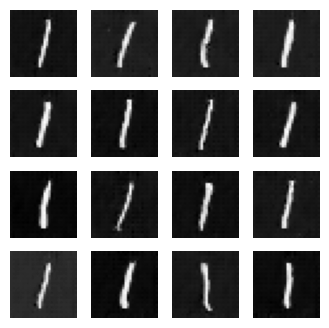

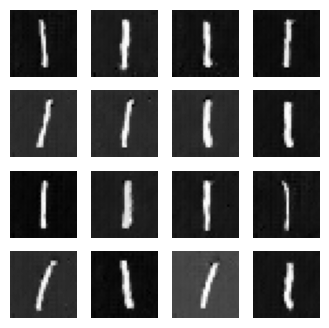

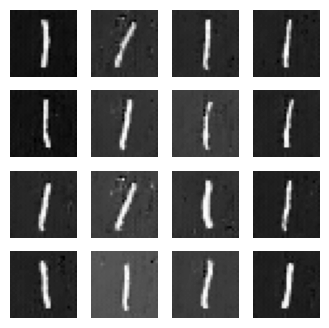

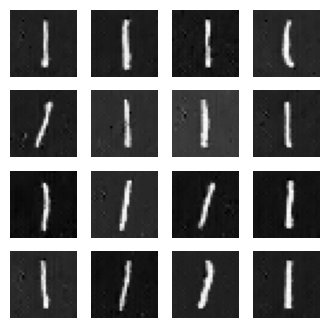

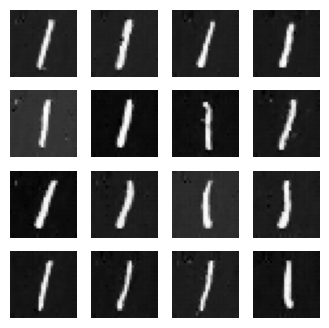

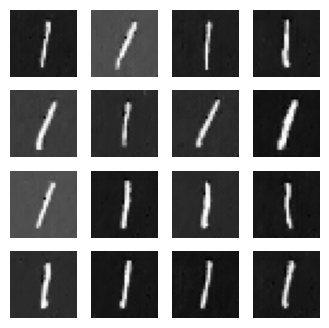

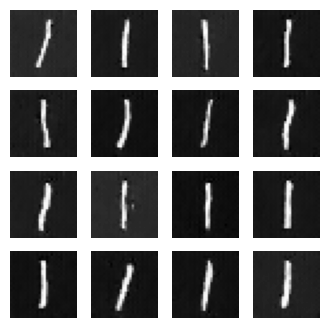

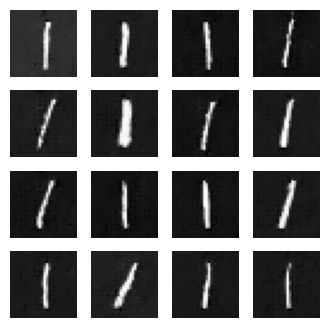

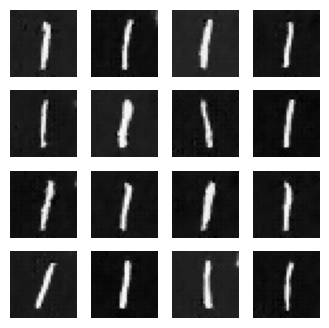

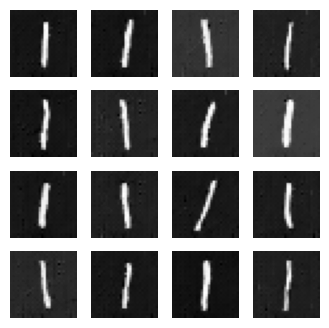

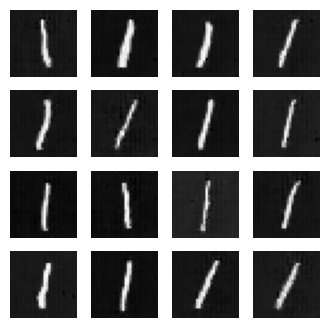

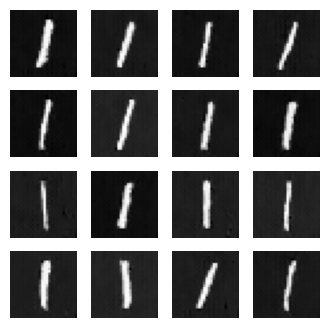

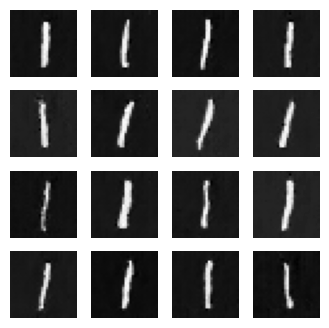

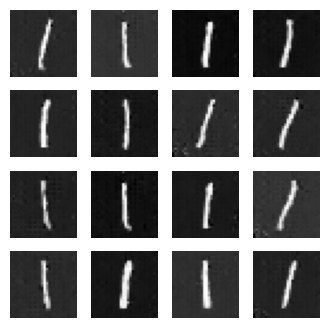

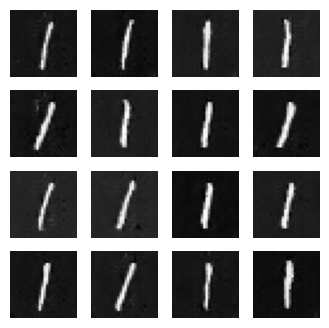

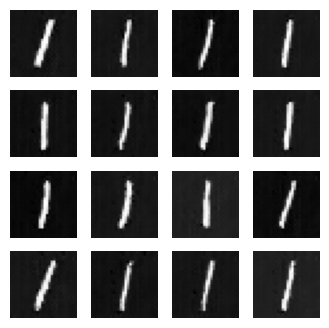

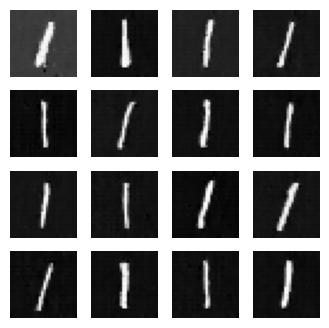

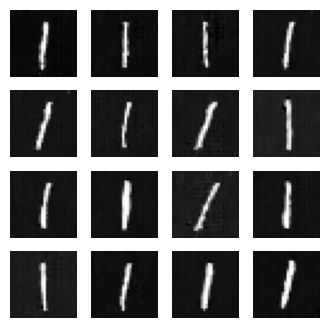

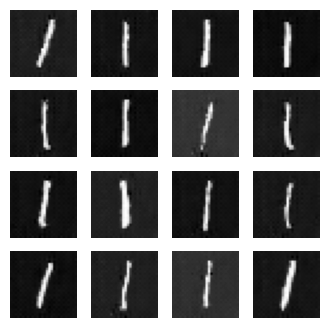

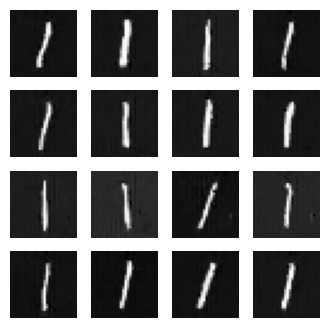

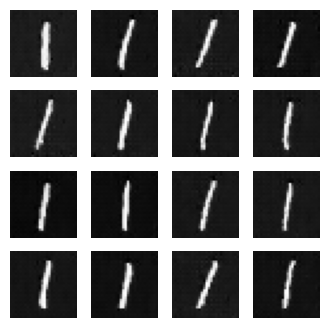

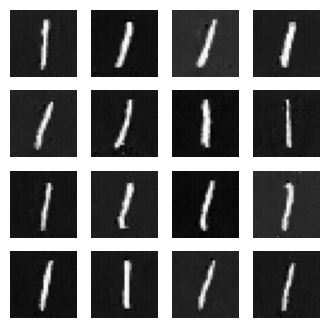

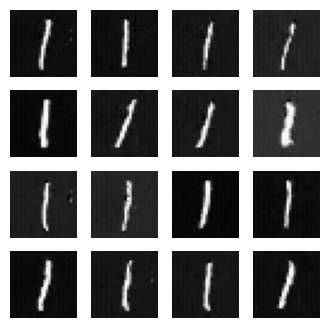

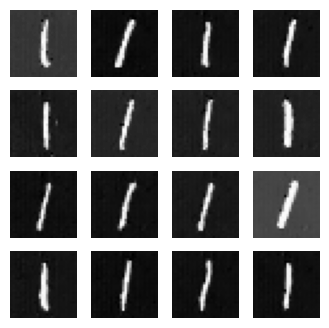

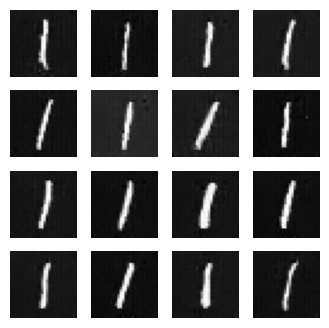

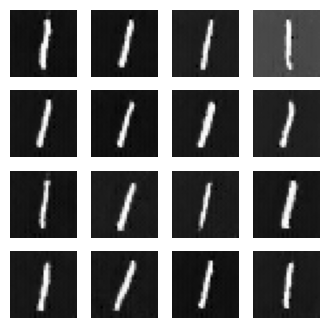

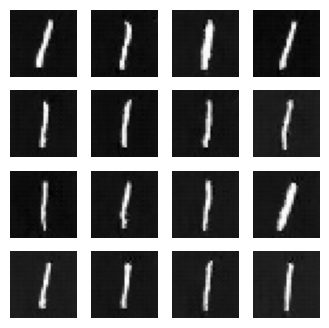

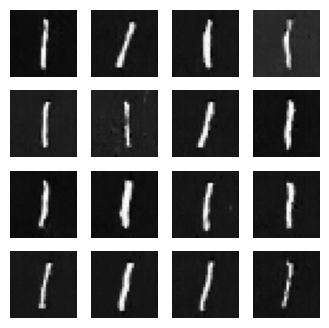

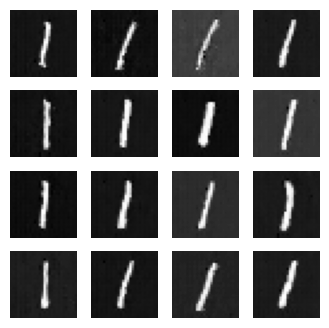

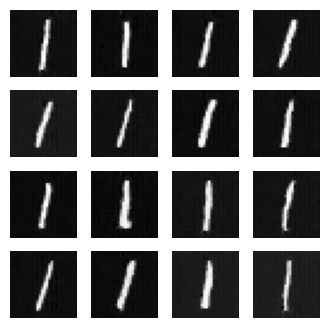

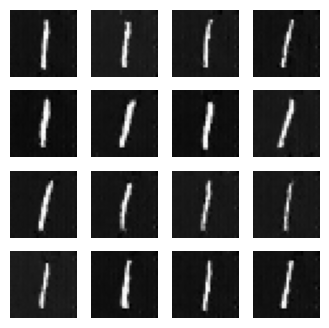

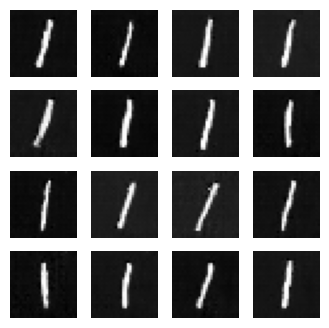

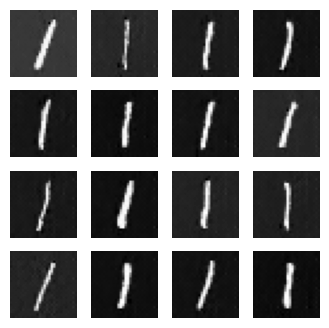

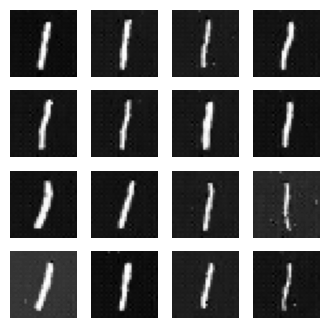

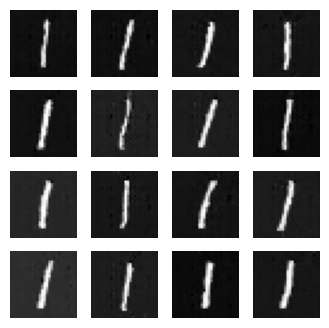

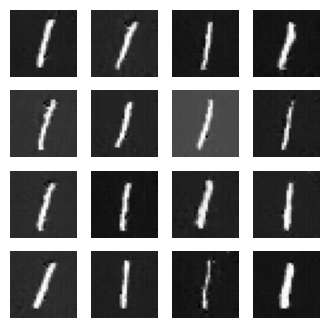

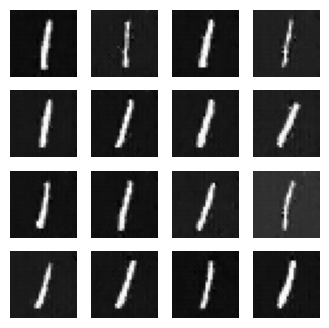

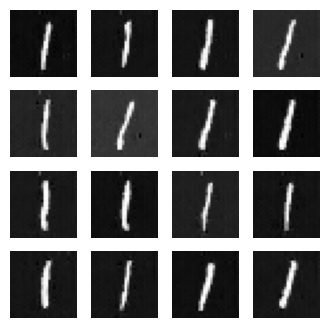

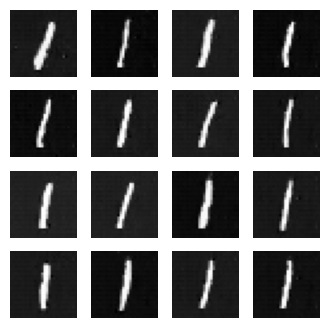

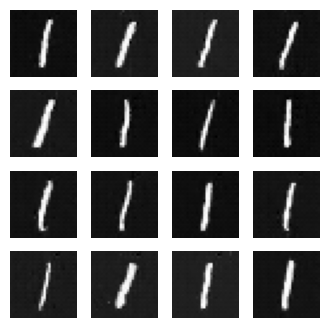

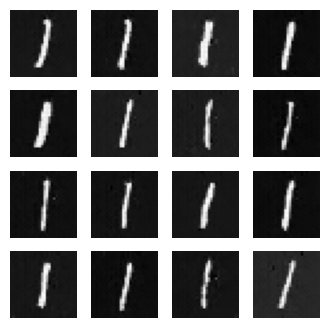

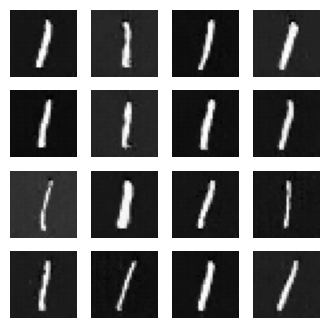

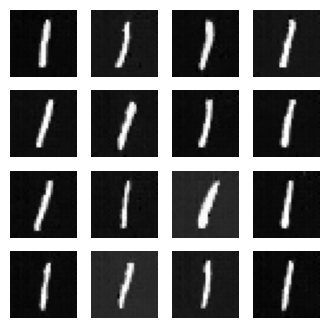

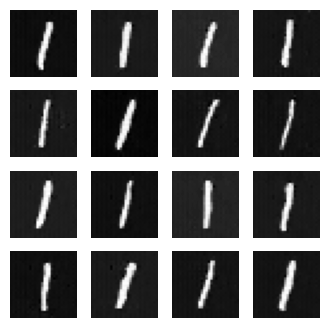

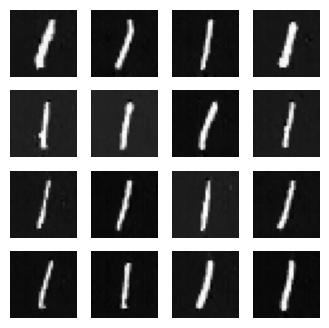

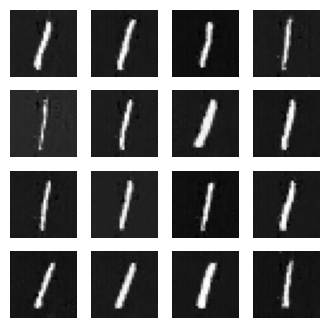

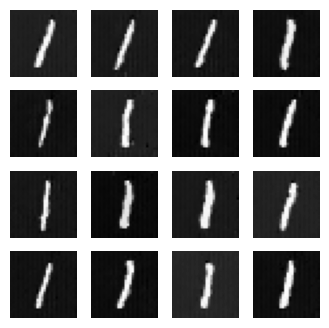

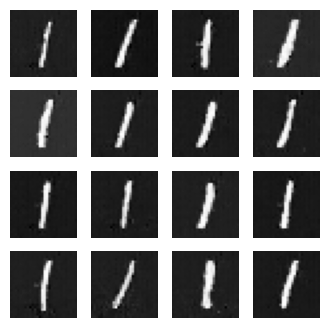

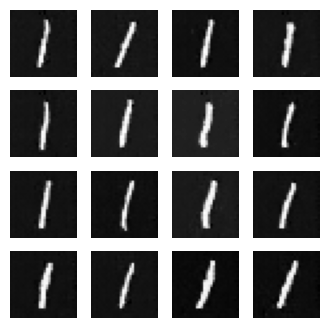

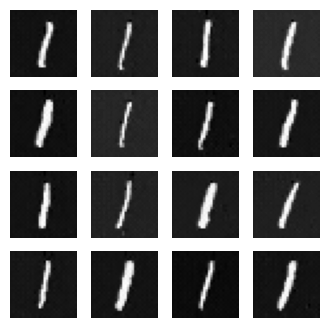

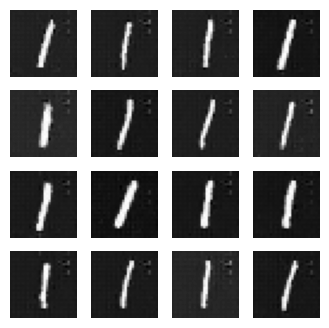

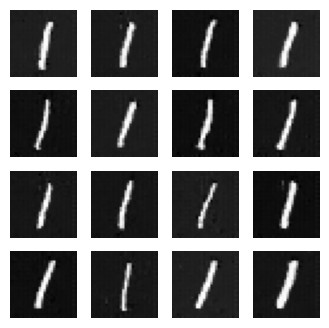

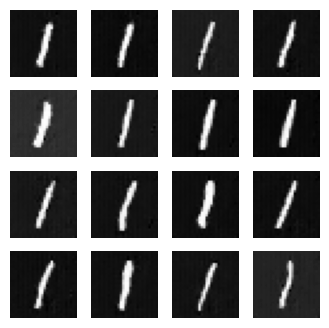

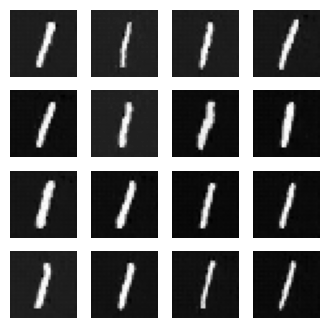

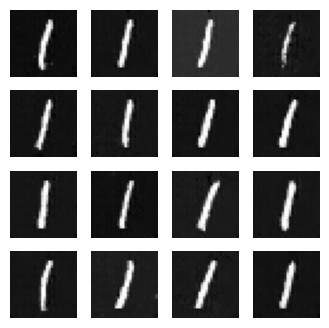

In [16]:
# Set hyperparameters
iterations = 50000
batch_size = 128
sample_interval = 500

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

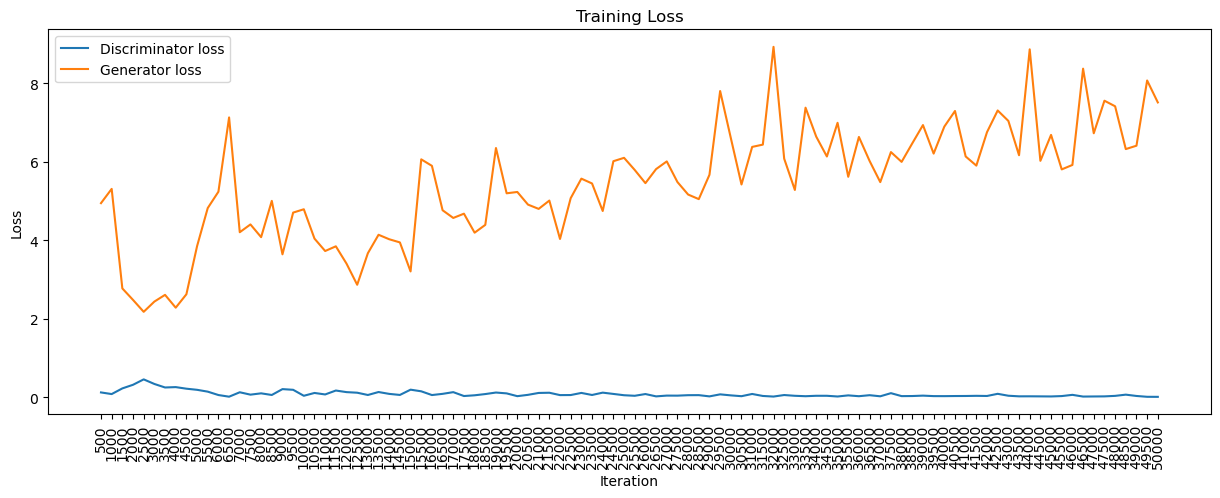

In [17]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

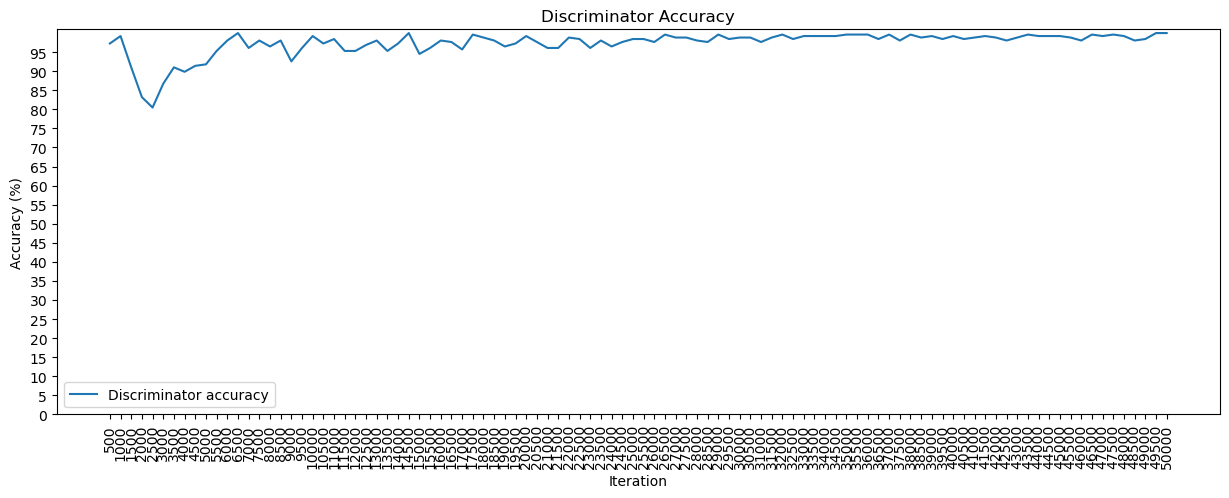

In [18]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

In [39]:
#this is too alert me when it finishes
import winsound 
 
# frequency is set to 524Hz
freq = 524
 
# duration is set to 1.5 seconds             
dur = 1500
              
winsound.Beep(freq, dur)